<a href="https://colab.research.google.com/github/Flychuban/Tyres-Condition/blob/main/TyreCondition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from matplotlib import pyplot as plt
import cv2
import pandas as pd
import numpy as np
import glob
from pathlib import Path
import tensorflow as tf
import os
from tensorflow.keras.applications import ResNetRS50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
train_path = Path('/content/drive/MyDrive/TyreConditionPrediction/data/Tire Textures/training_data')
test_path = Path('/content/drive/MyDrive/TyreConditionPrediction/data/Tire Textures/testing_data')
RANDOM_SEED = 10
EPOCHS = 100
BATCH_SIZE = 16

In [4]:
labels = os.listdir(train_path)
labels

['normal', 'cracked']

Let's make our dataset

In [5]:
def process_data(data):
  # creating instance of labelencoder

  path = Path(data)
  filepaths = list(path.glob(r'*/*.jpg'))
  labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))#Separating the label from filepath and storing it

  print(labels)
  df1 = pd.Series(filepaths, name='filepaths').astype(str)
  df2 = pd.Series(labels, name='labels')
  df = pd.concat([df1, df2], axis=1)
  return df

In [6]:
train_data = process_data(train_path)
test_data = process_data(test_path)
train_data

['normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal',

,filepaths,labels
0,/content/drive/MyDrive/TyreConditionPrediction...,normal
1,/content/drive/MyDrive/TyreConditionPrediction...,normal
2,/content/drive/MyDrive/TyreConditionPrediction...,normal
3,/content/drive/MyDrive/TyreConditionPrediction...,normal
4,/content/drive/MyDrive/TyreConditionPrediction...,normal
...,...,...
698,/content/drive/MyDrive/TyreConditionPrediction...,cracked
699,/content/drive/MyDrive/TyreConditionPrediction...,cracked
700,/content/drive/MyDrive/TyreConditionPrediction...,cracked
701,/content/drive/MyDrive/TyreConditionPrediction...,cracked


In [7]:
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=5,  # rotation
                                   width_shift_range=0.2,  # horizontal shift
                                   zoom_range=0.2,  # zoom
                                   horizontal_flip=True,  # horizontal flip
                                   brightness_range=[0.2,0.8],)

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                  rotation_range=5,  # rotation
                                   width_shift_range=0.2,  # horizontal shift
                                   zoom_range=0.2,  # zoom
                                   horizontal_flip=True,  # horizontal flip
                                   brightness_range=[0.2,0.8],
                                    validation_split=0.5)

In [8]:
train_images = train_generator.flow_from_dataframe(dataframe=train_data,
                                                   target_size=(224, 224),
                                                   batch_size = BATCH_SIZE,
                                                   x_col='filepaths',
                                                   y_col='labels',
                                                   class_mode='binary',
                                                   random_seed=RANDOM_SEED)

test_images = test_generator.flow_from_dataframe(dataframe=test_data,
                                                 target_size=(224, 224),
                                                 batch_size=BATCH_SIZE,
                                                 x_col='filepaths',
                                                 y_col = 'labels',
                                                 class_mode='binary',
                                                 random_seed = RANDOM_SEED,
                                                 subset='training'
                                                 )

val_images = test_generator.flow_from_dataframe(dataframe=test_data,
                                                   target_size=(224, 224),
                                                   batch_size = BATCH_SIZE,
                                                   x_col='filepaths',
                                                   y_col='labels',
                                                   class_mode='binary',
                                                   random_seed=RANDOM_SEED,
                                                   subset="validation"
                                                )


Found 703 validated image filenames belonging to 2 classes.
Found 163 validated image filenames belonging to 2 classes.
Found 162 validated image filenames belonging to 2 classes.


Build the model

In [9]:
pretrained_model = ResNetRS50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights = 'imagenet',
    pooling='max'
)

135360144/135360144 [==============================] - 1s 0us/step


In [10]:
pretrained_model.trainable = False # we make this cuz w don't train again the big model

In [11]:
inputs = pretrained_model.input

new_layer = Dense(60, activation='relu')(pretrained_model.output)
Dropout(0.15)
new_layer = Dense(90, activation='relu')(new_layer)
Dropout(0.3)
new_layer = Dense(120, activation ='relu')(new_layer)

outputs = Dense(1, activation = 'sigmoid')(new_layer)

In [12]:
model = Model(inputs=inputs, outputs=outputs)

In [13]:

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy']
)

In [14]:
early_stop = EarlyStopping(monitor='val_loss',patience=15)

Training

In [15]:
history = model.fit(train_images,
                    epochs=100,
                    steps_per_epoch=len(train_images),
                    validation_data=val_images,
                    validation_steps=len(val_images),
                    callbacks=[early_stop]
                    )

Epoch 1/100
44/44 [==============================] - 208s 4s/step - loss: 0.5378 - accuracy: 0.7326 - val_loss: 0.8553 - val_accuracy: 0.5679
Epoch 2/100
44/44 [==============================] - 57s 1s/step - loss: 0.4592 - accuracy: 0.7752 - val_loss: 0.4439 - val_accuracy: 0.8025
Epoch 3/100
44/44 [==============================] - 58s 1s/step - loss: 0.3361 - accuracy: 0.8535 - val_loss: 0.6778 - val_accuracy: 0.6605
Epoch 4/100
44/44 [==============================] - 55s 1s/step - loss: 0.3514 - accuracy: 0.8450 - val_loss: 0.3978 - val_accuracy: 0.8519
Epoch 5/100
44/44 [==============================] - 63s 1s/step - loss: 0.2813 - accuracy: 0.8777 - val_loss: 0.4372 - val_accuracy: 0.8086
Epoch 6/100
44/44 [==============================] - 58s 1s/step - loss: 0.3061 - accuracy: 0.8592 - val_loss: 0.4136 - val_accuracy: 0.8210
Epoch 7/100
44/44 [==============================] - 56s 1s/step - loss: 0.2964 - accuracy: 0.8834 - val_loss: 0.3723 - val_accuracy: 0.8025
Epoch 8/100


In [16]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  plt.plot(epochRange,history.history['accuracy'])
  plt.plot(epochRange,history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train','Validation'],loc='upper left')
  plt.show()

  plt.plot(epochRange,history.history['loss'])
  plt.plot(epochRange,history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train','Validation'],loc='upper left')
  plt.show()

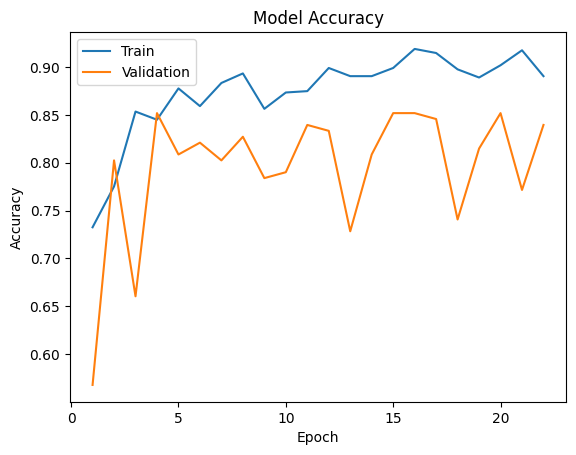

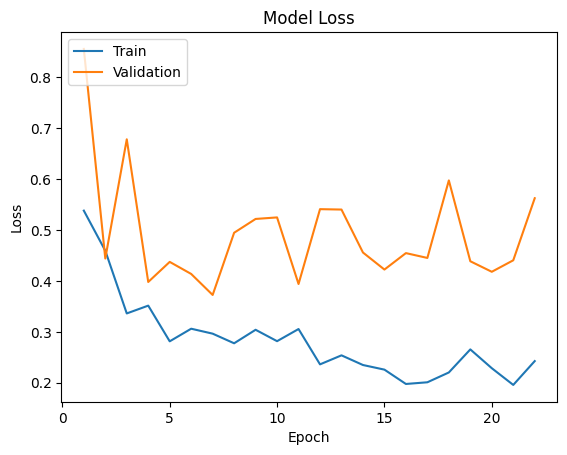

In [18]:
plotLearningCurve(history,22)

In [19]:
model.evaluate(test_images)

11/11 [==============================] - 15s 1s/step - loss: 2.9272 - accuracy: 0.2331


[2.927156686782837, 0.23312883079051971]

In [ ]:
model.save("tyre_condition_model_6.h5")

In [28]:
model = tf.keras.models.load_model('/content/drive/MyDrive/TyreConditionPrediction/tyre_condition_model_4.h5')

KeyboardInterrupt: ignored

In [20]:
from tensorflow.keras.preprocessing import image

test_image = image.load_img('/content/drive/MyDrive/TyreConditionPrediction/data/Tire Textures/testing_data/cracked/IMG_4277.jpg', target_size = (224, 224)) # Get the image
transformed_image = image.img_to_array(test_image) # Transform image to array
transformed_image = np.expand_dims(transformed_image, axis=0) # Expand dims to make a batch of 1 image
prediction = model.predict(transformed_image)

print(prediction)

if prediction[0] < 0.5:
  print("This tyre HAS a problem!")
else:
  print("This tyre HASN'T problem!")

1/1 [==============================] - 2s 2s/step
[[0.9999504]]
This tyre HASN'T problem!
